In [115]:
# imports
import pandas as pd
import sklearn as skl
import plotly
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras_tuner as kt

In [116]:
#load CSVs
medals = pd.read_csv("Resources/medals_cleaned.csv")
results = pd.read_csv("Resources/clean_olympic_results.csv")
hosts = pd.read_csv("Resources/hosts_cleaned.csv")
athletes = pd.read_csv("Resources/athletes_cleaned.csv")


In [117]:
#Merge olympics_hosts and olympics_medals. Code based off eda from https://www.kaggle.com/kalilurrahman/olympic-games-eda

olympics_results = pd.merge(hosts, medals,
                           left_on=  ['game_slug'],
                           right_on= ['slug_game'],
                           how = 'left')
olympics_results.head(10)

,game_slug,game_end_date,game_start_date,game_location,game_name,game_season,game_year,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,country_name,country_code,country_3_letter_code
0,tokyo-2020,2021-08-08,2021-07-23,Japan,Tokyo 2020,Summer,2020,Shooting,tokyo-2020,Trap Mixed Team,Mixed,GOLD,GameTeam,Spain,ES,ESP
1,tokyo-2020,2021-08-08,2021-07-23,Japan,Tokyo 2020,Summer,2020,Shooting,tokyo-2020,Trap Mixed Team,Mixed,GOLD,GameTeam,Spain,ES,ESP
2,tokyo-2020,2021-08-08,2021-07-23,Japan,Tokyo 2020,Summer,2020,Shooting,tokyo-2020,Trap Mixed Team,Mixed,SILVER,GameTeam,San Marino,SM,SMR
3,tokyo-2020,2021-08-08,2021-07-23,Japan,Tokyo 2020,Summer,2020,Shooting,tokyo-2020,Trap Mixed Team,Mixed,SILVER,GameTeam,San Marino,SM,SMR
4,tokyo-2020,2021-08-08,2021-07-23,Japan,Tokyo 2020,Summer,2020,Shooting,tokyo-2020,Trap Mixed Team,Mixed,BRONZE,GameTeam,United States of America,US,USA
5,tokyo-2020,2021-08-08,2021-07-23,Japan,Tokyo 2020,Summer,2020,Shooting,tokyo-2020,Trap Mixed Team,Mixed,BRONZE,GameTeam,United States of America,US,USA
6,tokyo-2020,2021-08-08,2021-07-23,Japan,Tokyo 2020,Summer,2020,Shooting,tokyo-2020,50m Rifle 3 Positions women,Women,SILVER,Athlete,ROC,ROC,ROC
7,tokyo-2020,2021-08-08,2021-07-23,Japan,Tokyo 2020,Summer,2020,Shooting,tokyo-2020,50m Rifle 3 Positions women,Women,BRONZE,Athlete,ROC,ROC,ROC
8,tokyo-2020,2021-08-08,2021-07-23,Japan,Tokyo 2020,Summer,2020,Shooting,tokyo-2020,50m Rifle 3 Positions women,Women,GOLD,Athlete,Switzerland,CH,SUI
9,tokyo-2020,2021-08-08,2021-07-23,Japan,Tokyo 2020,Summer,2020,Shooting,tokyo-2020,50m Rifle 3 Positions Men,Men,BRONZE,Athlete,Serbia,RS,SRB


In [118]:
clean_olympics_results= olympics_results.drop(['game_end_date', 'game_start_date', 'game_slug', 'game_year', 'event_title', 'country_3_letter_code', 'slug_game', 'country_code', 'game_name'], 1)

/Users/rafaelpeterson/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [119]:
clean_olympics_results.columns

Index(['game_location', 'game_season', 'discipline_title', 'event_gender',
       'medal_type', 'participant_type', 'country_name'],
      dtype='object')

In [120]:
# condensing country names

clean_olympics_results["game_location"].replace({"Russian Federation": "Russia",
                        "Soviet Union": "Russia",
                        "Unified team": "Russia",
                        "West Germany": "Germany",
                        "East Germany": "Germany",
                        "German Democratic Republic (Germany)": "Germany",
                        "Federal Republic of Germany": "Germany",
                        "Australia, Sweden" : "Australia",
                        "USSR" : "Russia"}, inplace=True)

clean_olympics_results["country_name"].replace({"Russian Federation": "Russia",
                        "Soviet Union": "Russia",
                        "Unified team": "Russia",
                        "West Germany": "Germany",
                        "East Germany": "Germany",
                        "German Democratic Republic (Germany)": "Germany",
                        "Federal Republic of Germany": "Germany",
                        "Australia, Sweden" : "Australia",
                        "USSR" : "Russia"}, inplace=True)

In [121]:
# create CSV
clean_olympics_results.to_csv('Resources/clean_olympic_results.csv', index=False)

In [122]:
# binning countries
country_counts = clean_olympics_results.country_name.value_counts()
country_counts

United States of America    3063
Germany                     1959
Russia                      1871
Great Britain               1041
France                       932
                            ... 
Mauritius                      1
Gabon                          1
Guatemala                      1
Cyprus                         1
Montenegro                     1
Name: country_name, Length: 151, dtype: int64

(0.0, 800.0)

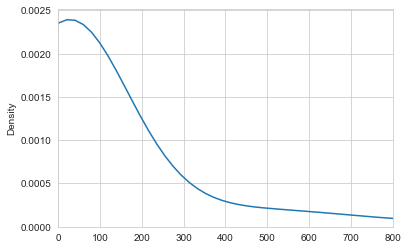

In [123]:
# checking density
sns.set_style('whitegrid')
gfg = sns.kdeplot(np.array(country_counts))
gfg.set_xlim(0, 800)


In [124]:
# Determine which values to replace
replace_countries = list(country_counts[country_counts < 600].index)

# Replace in DataFrame
for country in replace_countries:
    clean_olympics_results.country_name = clean_olympics_results.country_name.replace(country,"Other")


# Check to make sure binning was successful
clean_olympics_results.country_name.value_counts()

Other                         9557
United States of America      3063
Germany                       1959
Russia                        1871
Great Britain                 1041
France                         932
People's Republic of China     790
Italy                          785
Sweden                         689
Australia                      623
Name: country_name, dtype: int64

In [125]:
location_counts = clean_olympics_results.game_location.value_counts()
location_counts

United States        2802
Japan                2027
Great Britain        1823
Australia            1501
Greece               1148
Republic of Korea    1128
Canada               1081
Germany              1075
Brazil               1063
China                1044
France               1033
Russia                984
Spain                 887
Italy                 835
Mexico                551
Finland               465
Belgium               457
Netherlands           331
Sweden                323
Norway                268
Austria               237
Yugoslavia            129
Switzerland           118
Name: game_location, dtype: int64

(0.0, 1500.0)

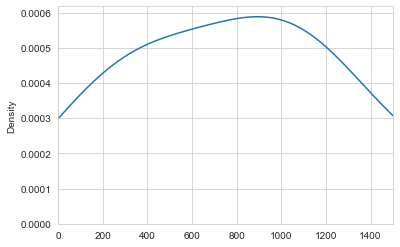

In [126]:
#checking density
sns.set_style('whitegrid')
gfg = sns.kdeplot(np.array(location_counts))
gfg.set_xlim(0, 1500)

In [127]:
# Determine which values to replace
replace_locations = list(country_counts[country_counts < 700].index)

# Replace in DataFrame
for country in replace_locations:
    clean_olympics_results.game_location = clean_olympics_results.game_location.replace(country,"Other")


# Check to make sure binning was successful
clean_olympics_results.game_location.value_counts()

Other            11714
United States     2802
Great Britain     1823
Germany           1075
China             1044
France            1033
Russia             984
Italy              835
Name: game_location, dtype: int64

In [128]:
titles = clean_olympics_results.discipline_title.value_counts()
titles

Athletics            3076
Swimming             1763
Wrestling            1354
Rowing               1068
Boxing                996
                     ... 
Jeu de Paume            3
Water Motorsports       3
Roque                   3
Cricket                 2
Basque Pelota           2
Name: discipline_title, Length: 86, dtype: int64

(0.0, 1500.0)

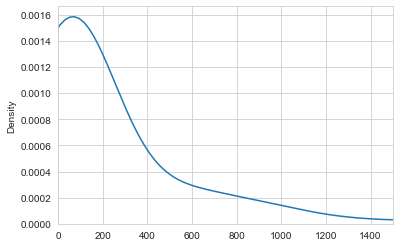

In [129]:
#checking density
sns.set_style('whitegrid')
gfg = sns.kdeplot(np.array(titles))
gfg.set_xlim(0, 1500)

In [130]:
# Determine which values to replace
title_replacements = list(titles[titles < 790].index)

# Replace in DataFrame
for discipline in title_replacements:
    clean_olympics_results.discipline_title = clean_olympics_results.discipline_title.replace(discipline,"Other")


# Check to make sure binning was successful
clean_olympics_results.discipline_title.value_counts()

Other                  10407
Athletics               3076
Swimming                1763
Wrestling               1354
Rowing                  1068
Boxing                   996
Gymnastics Artistic      979
Shooting                 869
Canoe Sprint             798
Name: discipline_title, dtype: int64

In [131]:
# # categorizing medal type into int (1 = gold, 2 = silver, 3 = bronze)
# # loc
# clean_olympics_results.loc[(clean_olympics_results.medal_type =='GOLD'), 'medal_type']='1'
# clean_olympics_results.loc[(clean_olympics_results.medal_type =='SILVER'), 'medal_type']='2'
# clean_olympics_results.loc[(clean_olympics_results.medal_type =='BRONZE'), 'medal_type']='3'
    

In [132]:
# # converting column to int
# clean_olympics_results['medal_type']= clean_olympics_results['medal_type'].astype(int)

In [133]:
# Generate our categorical variable list
olympics_cat = clean_olympics_results.dtypes[clean_olympics_results.dtypes == "object"].index.tolist()


In [134]:
# Check the number of unique values in each column
clean_olympics_results[olympics_cat].nunique()

game_location        8
game_season          2
discipline_title     9
event_gender         4
medal_type           3
participant_type     2
country_name        10
dtype: int64

In [135]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(clean_olympics_results[olympics_cat]))

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(olympics_cat)
encode_df.head()

/Users/rafaelpeterson/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,game_location_China,game_location_France,game_location_Germany,game_location_Great Britain,game_location_Italy,game_location_Other,game_location_Russia,game_location_United States,game_season_Summer,game_season_Winter,...,country_name_Australia,country_name_France,country_name_Germany,country_name_Great Britain,country_name_Italy,country_name_Other,country_name_People's Republic of China,country_name_Russia,country_name_Sweden,country_name_United States of America
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [136]:
encode_df.columns

Index(['game_location_China', 'game_location_France', 'game_location_Germany',
       'game_location_Great Britain', 'game_location_Italy',
       'game_location_Other', 'game_location_Russia',
       'game_location_United States', 'game_season_Summer',
       'game_season_Winter', 'discipline_title_Athletics',
       'discipline_title_Boxing', 'discipline_title_Canoe Sprint',
       'discipline_title_Gymnastics Artistic', 'discipline_title_Other',
       'discipline_title_Rowing', 'discipline_title_Shooting',
       'discipline_title_Swimming', 'discipline_title_Wrestling',
       'event_gender_Men', 'event_gender_Mixed', 'event_gender_Open',
       'event_gender_Women', 'medal_type_BRONZE', 'medal_type_GOLD',
       'medal_type_SILVER', 'participant_type_Athlete',
       'participant_type_GameTeam', 'country_name_Australia',
       'country_name_France', 'country_name_Germany',
       'country_name_Great Britain', 'country_name_Italy',
       'country_name_Other', 'country_name_Peopl

In [137]:
# Merge one-hot encoded features and drop the originals
clean_olympics_results = clean_olympics_results.merge(encode_df,left_index=True, right_index=True)
clean_olympics_results = clean_olympics_results.drop(olympics_cat,1)
clean_olympics_results.head()

/Users/rafaelpeterson/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,game_location_China,game_location_France,game_location_Germany,game_location_Great Britain,game_location_Italy,game_location_Other,game_location_Russia,game_location_United States,game_season_Summer,game_season_Winter,...,country_name_Australia,country_name_France,country_name_Germany,country_name_Great Britain,country_name_Italy,country_name_Other,country_name_People's Republic of China,country_name_Russia,country_name_Sweden,country_name_United States of America
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [138]:
# splitting 

y = clean_olympics_results["medal_type_GOLD"].values
X = clean_olympics_results.drop(['medal_type_BRONZE', 'medal_type_GOLD',
       'medal_type_SILVER'],1).values
# Reshape y to vertical
y = y.reshape(-1,1)
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

/Users/rafaelpeterson/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


In [139]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)



In [140]:
# # Create a method that creates a new Sequential model with hyperparameter options
# def create_model(hp):
#     nn_model = tf.keras.models.Sequential()

#     # Allow kerastuner to decide which activation function to use in hidden layers
#     activation = hp.Choice('activation',['relu','tanh','sigmoid'])
    
#     # Allow kerastuner to decide number of neurons in first layer
#     nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
#         min_value=1,
#         max_value=10,
#         step=2), activation=activation, input_dim=2))

#     # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
#     for i in range(hp.Int('num_layers', 1, 6)):
#         nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
#             min_value=1,
#             max_value=10,
#             step=2),
#             activation=activation))
    
#     nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

#     # Compile the model
#     nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
#     return nn_model

In [141]:
# # Import the kerastuner library
# import keras_tuner as kt

# tuner = kt.Hyperband(
#     create_model,
#     objective="val_accuracy",
#     max_epochs=20,
#     hyperband_iterations=2)

In [142]:
# Run the kerastuner search for best hyperparameters
# tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

In [143]:
# # Evaluate the model using the test data
# model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

<h2> Trying randomForest modeling </h2>

In [144]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

Note: Remainder of code derived from https://github.com/dnishimoto/python-deep-learning/blob/master/Random%20Forest%20Tennis.ipynb

/Users/rafaelpeterson/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Text(0.5, 257.44, 'Predicted label')

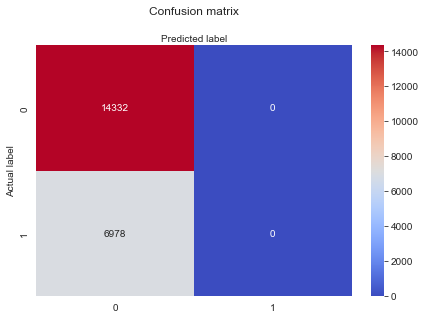

In [145]:

pipeline= Pipeline([
   ('scaler',StandardScaler()),
    ('pca', PCA()),
   ('clf',RandomForestClassifier(n_estimators=5,max_depth=1,min_samples_leaf=3, max_features=6, random_state=42))
])
pipeline.fit(X_train,y_train)

#Predicting y for X_val
y_pred = pipeline.predict(X)
cm = confusion_matrix(y,y_pred)

class_names=[1,2]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="coolwarm" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [147]:
dt= DecisionTreeClassifier(max_depth=1,min_samples_leaf=3, max_features=6, random_state=42)
dt.fit(X_train, y_train)


chosen_tree=pipeline['clf'].estimators_[4]

In [148]:
# RandomForest classifier
parameter_grid={'n_estimators':[1,2,3,4,5],'max_depth':[2,4,6,8,10],'min_samples_leaf': 
[1,2,4],'max_features':[1,2,3,4,5,6,7,8]}

number_models=4
random_RandomForest_class=RandomizedSearchCV(
estimator=pipeline['clf'],
param_distributions=parameter_grid,
n_iter=number_models,
scoring='accuracy',
n_jobs=2,
cv=4,
refit=True,
return_train_score=True)

random_RandomForest_class.fit(X_train,y_train.ravel())
predictions=random_RandomForest_class.predict(X)

print("Accuracy Score",accuracy_score(y,predictions));
print("Best params",random_RandomForest_class.best_params_)
print("Best score",random_RandomForest_class.best_score_)


Accuracy Score 0.6767714687939934
Best params {'n_estimators': 3, 'min_samples_leaf': 1, 'max_features': 8, 'max_depth': 6}
Best score 0.6703792340525757


Principle component analysis show the importance of each feature


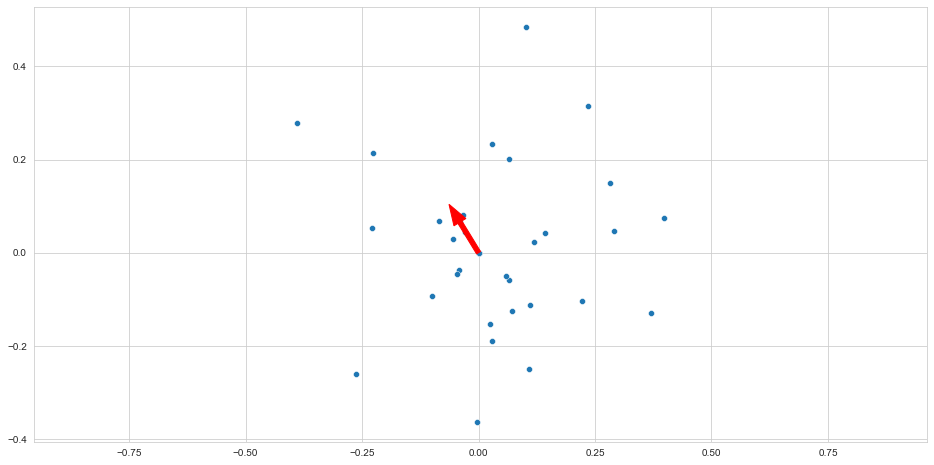

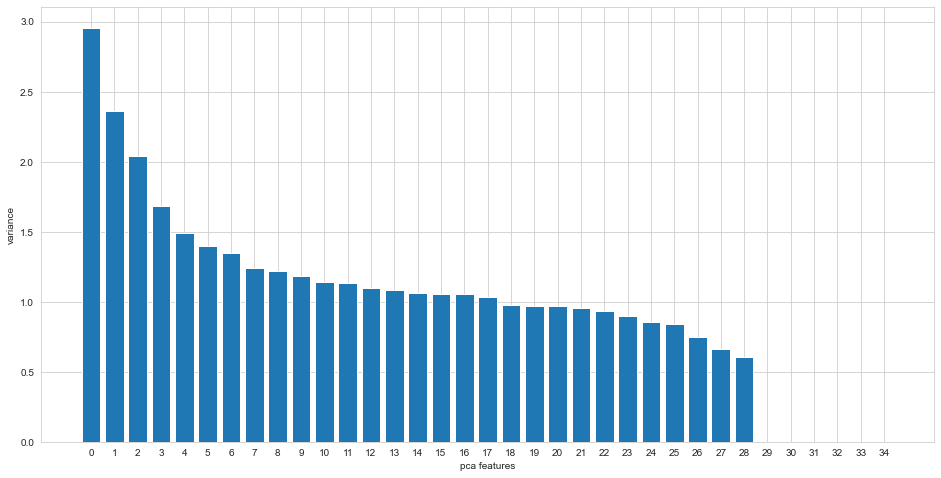

In [149]:
print('Principle component analysis show the importance of each feature')
pca=pipeline['pca']
pca_features=pca.components_
xs = pca_features[:,0]

fig,ax = plt.subplots(figsize=(16,8))
# Assign 1st column of pca_features: ys
ys = pca_features[:,1]
# Scatter plot xs vs ys
sns.scatterplot(x=xs, y=ys)

mean = pca.mean_
first_pc = pca.components_[0,:]
# Plot first_pc as an arrow, starting at mean
plt.arrow(mean[0],mean[1], first_pc[0], first_pc[1], color='red', width=0.01)

plt.axis('equal')
plt.show()

fig,ax = plt.subplots(figsize=(16,8))
features = range(pca.n_components_)
ax.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('pca features')
plt.show()